## Algorytm Groovera dla n=2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.primitives import Sampler as PSampler
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, Sampler

In [2]:
n = 2
grover_circuit = QuantumCircuit(n)

def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

In [3]:
grover_circuit.cz(0,1)
grover_circuit.draw()

┌───┐   
q_0: ┤ H ├─■─
     ├───┤ │ 
q_1: ┤ H ├─■─
     └───┘

In [4]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

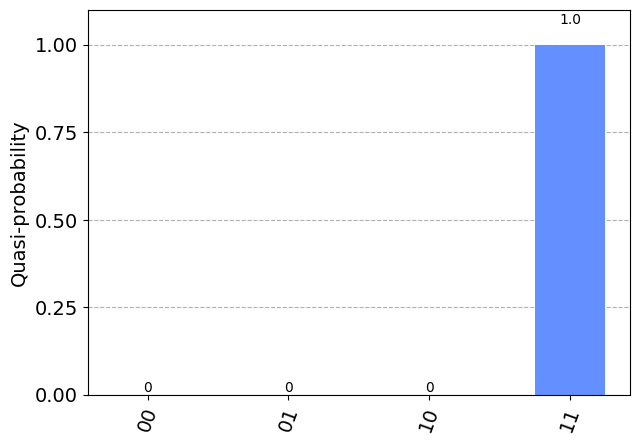

In [5]:
state = Statevector.from_instruction(grover_circuit)
ideal_distribution = state.probabilities_dict()
plot_histogram(ideal_distribution)


/home/michal/kwantowka/env/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:878: UserWarning: Cloud simulators have been deprecated and will be removed on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)


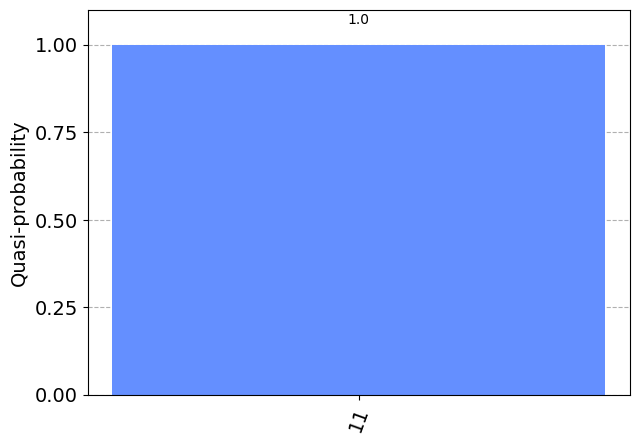

In [6]:
grover_circuit.measure_all()
service = QiskitRuntimeService()
backend=service.backend('ibmq_qasm_simulator')
with Batch(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run(
        circuits=[grover_circuit],
        shots=100,
    )
    result_sim = job.result()
plot_histogram(result_sim.quasi_dists[0].binary_probabilities())

## Algorytm Groovera dla sudoku

In [8]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import C4XGate, C3XGate
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, Sampler
from qiskit.visualization import plot_histogram

def diffuser(qc, nqubits):
    for qubit in nqubits:
        qc.h(qubit)
    for qubit in nqubits:
        qc.x(qubit)
    qc.h(nqubits[-1])
    qc.append(C3XGate(),nqubits)
    qc.h(nqubits[-1])
    for qubit in nqubits:
        qc.x(qubit)
    for qubit in nqubits:
        qc.h(qubit)
    return qc

clause_list = [[0,1], [0,2], [1,3], [2,3]]

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

def sudoku_oracle(qc, clause_list, clause_qubits, output_qubit):
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1
    print([clause_qubits[0], clause_qubits[1], clause_qubits[2], clause_qubits[3], output_qubit[0]])
    qc.append(C4XGate(),[clause_qubits[0], clause_qubits[1], clause_qubits[2], clause_qubits[3], output_qubit[0]])
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')

qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

qc.initialize([1, -1] / np.sqrt(2), output_qubit)
qc.h(var_qubits)
qc.h(output_qubit)
qc.barrier()

N = 2**(4**2 - 8)
m = 2**4
iterations = int(np.floor(np.pi / 4 * np.sqrt(N / m)))

for _ in range(iterations):
    sudoku_oracle(qc, clause_list, clause_qubits, output_qubit)
    qc.barrier()
    diffuser(qc, var_qubits)
    qc.barrier()

qc.measure(var_qubits, cbits)
qc.draw(fold=-1)

[Qubit(QuantumRegister(4, 'c'), 0), Qubit(QuantumRegister(4, 'c'), 1), Qubit(QuantumRegister(4, 'c'), 2), Qubit(QuantumRegister(4, 'c'), 3), Qubit(QuantumRegister(1, 'out'), 0)]
[Qubit(QuantumRegister(4, 'c'), 0), Qubit(QuantumRegister(4, 'c'), 1), Qubit(QuantumRegister(4, 'c'), 2), Qubit(QuantumRegister(4, 'c'), 3), Qubit(QuantumRegister(1, 'out'), 0)]
[Qubit(QuantumRegister(4, 'c'), 0), Qubit(QuantumRegister(4, 'c'), 1), Qubit(QuantumRegister(4, 'c'), 2), Qubit(QuantumRegister(4, 'c'), 3), Qubit(QuantumRegister(1, 'out'), 0)]


┌───┐                    ░                                                                                       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░                                                                                       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░                                                                                       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░ ┌─┐         
    v_0: ─────────────┤ H ├────────────────────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤M├─────────
                      ├───┤                    ░   │         │                                  │         │                            ░ ├───┤├───┤       │  ├───┤├───┤      ░   │         │                                  │         │                            ░ ├───┤├───┤       │  ├───┤├───┤      ░   │         │                                  │         │                            ░ ├───┤├───┤       │  ├───┤├───┤      ░ └╥┘┌─┐      
    v_1: ─────────────┤ H ├────────────────────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──╫─┤M├──────
                      ├───┤                    ░   │    │    │         │                        │    │    │         │                  ░ ├───┤├───┤       │  ├───┤├───┤      ░   │    │    │         │                        │    │    │         │                  ░ ├───┤├───┤       │  ├───┤├───┤      ░   │    │    │         │                        │    │    │         │                  ░ ├───┤├───┤       │  ├───┤├───┤      ░  ║ └╥┘┌─┐   
    v_2: ─────────────┤ H ├────────────────────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──╫──╫─┤M├───
                      ├───┤                    ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░  ║  ║ └╥┘┌─┐
    v_3: ─────────────┤ H ├────────────────────░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫──╫──╫─┤M├
                      └───┘                    ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║  ║  ║ └╥┘
    c_0: ──────────────────────────────────────░─┤ X ├┤ X ├──┼

/home/michal/kwantowka/env/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:878: UserWarning: Cloud simulators have been deprecated and will be removed on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)


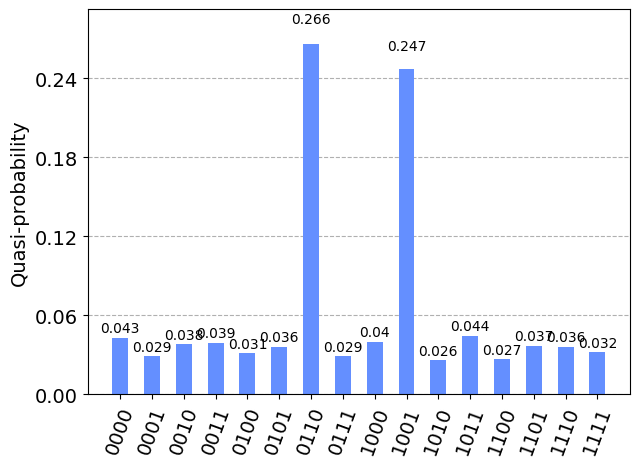

In [5]:
service = QiskitRuntimeService()
backend=service.backend('ibmq_qasm_simulator')
with Batch(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run(
        circuits=[qc],
        shots=1000,
    )
    result_sim = job.result()
plot_histogram(result_sim.quasi_dists[0].binary_probabilities())